**This is a simple example to build a one layer neural network classifier with random data and witouth using any libraries**

In [1]:
#Basics
import numpy as np
from scipy.spatial.distance import pdist
from sklearn.datasets import make_blobs

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Metrics
from sklearn.metrics import confusion_matrix

#Extras
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [119]:
def random_data(min_samples=500, max_samples=5000, min_cent=2, max_cent=10, min_std=0.1, max_std=5, 
                min_features=2, max_features=10, min_box = -10, max_box = 10):
    
    samples = np.random.randint(min_samples,max_samples+1)
    centroids = np.random.randint(min_cent,max_cent+1)
    std = np.random.uniform(min_std,max_std)
    features = np.random.randint(min_features,max_features+1)
    
    X, y, centers = make_blobs(n_samples=samples, centers=centroids, cluster_std=std, n_features = features, 
                               center_box = (min_box,max_box), return_centers=True)
    
    max_dist = np.sqrt((abs(min_box*2)**2) + (abs(max_box*2)**2))
    dist = np.mean(pdist(centers))
    std_norm = (std-min_std)/(max_std-min_std)
    cent_norm = (centroids-min_cent)/(max_cent-min_cent)
    dist_norm = dist/max_dist
    
    index = (std_norm/dist_norm)*cent_norm
    if index > 1:
        index = 1
    
    fig = plt.figure(figsize=(16,11))
    sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar=plt.colorbar(sm,location="top",ticks=np.linspace(0, 1, 5))
    cbar.ax.axvline(x=(index - 0) / (1 - 0), color='w', linewidth=3,label=index)
    cbar.set_ticklabels(["Very easy", "Easy", "Average", "Hard", "Very hard"])
    cbar.set_label("Task's difficulty",fontsize=20,weight="bold")
    
    for tick_label in cbar.ax.get_xticklabels():
        tick_label.set_fontweight('bold')
        tick_label.set_fontsize(15)
    plt.scatter(x=X[:,0],y=X[:,1],c=y,edgecolor="k",s=100)
    plt.scatter(x=centers[:,0],y=centers[:,1],c="r",s=500,edgecolor="k")
    plt.xlabel("Feature 1",weight="bold",fontsize=15)
    plt.ylabel("Feature 2",weight="bold",fontsize=15)
    plt.title("{} features defining {} examples in {} clusters with {:.2f} std"
              .format(features,samples,centroids,std),weight="bold",fontsize=20)
    plt.tight_layout();
    
    return X, y, centers

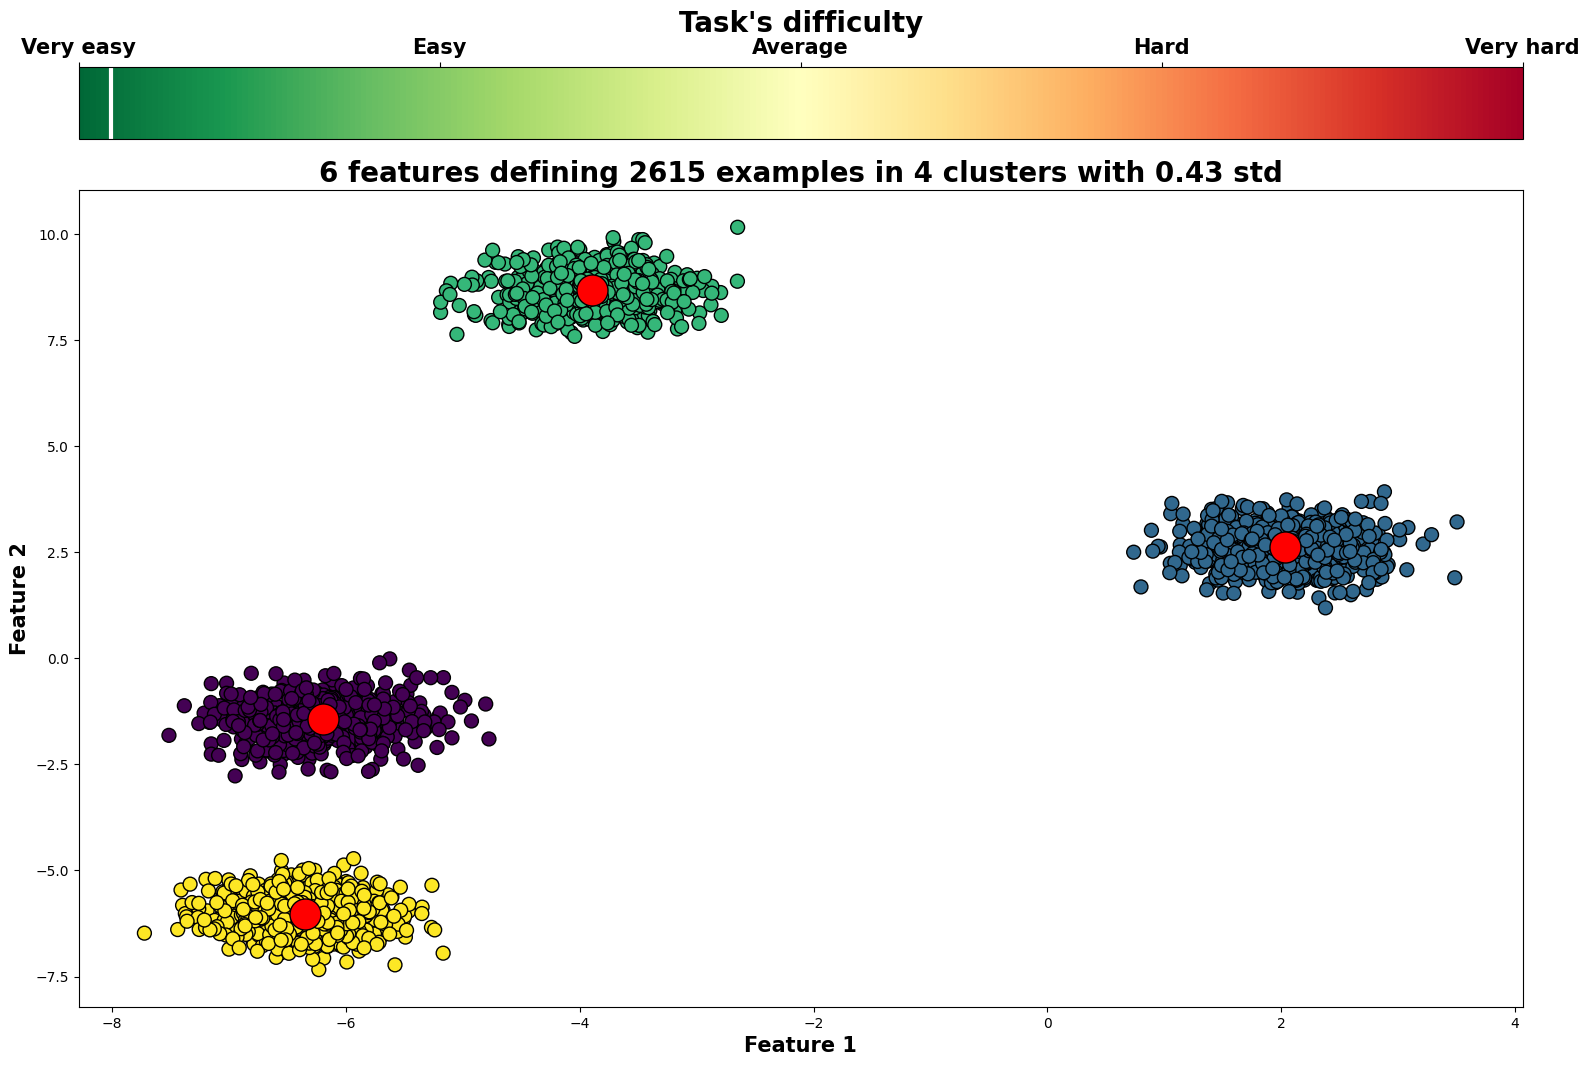

In [196]:
X, y, centers = random_data()

In [130]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, stratify = y, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, stratify = y_val,random_state=1)
scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_val = scl.transform(X_val)
X_test = scl.transform(X_test)
print("Train dimension: {}".format(X_train.shape[0]))
print("Val dimension: {}".format(X_val.shape[0]))
print("Test dimension: {}".format(X_test.shape[0]))

Train dimension: 2068
Val dimension: 258
Test dimension: 259


In [131]:
def classifier_NN(train_var,train_tar,val_var,val_tar,epochs=200,lr=0.001,verbose=10,bs=32,es=30,dropout=0.2,plot=1):
    #np.random.seed(0)
    #Dimensioni e classi
    features = train_var.shape[1]
    classes = len(np.unique(train_tar))
    best_val_loss = float('inf')
    no_improvment_epochs = 0
    dropout_rate = min(1., max(0., dropout))
    
    #Parametri
    weights = np.random.randn(features, classes)
    bias = np.zeros((1, classes))
    
    #Plotting lists
    train_loss_plot = []
    val_loss_plot = []
    
    #Training epochs
        #Randomizing examples in train set
    for epoch in tqdm(range(epochs),desc="Training epochs"):
        rnd_indexes = np.random.permutation(len(train_var))
        train_var_shuffle = train_var[rnd_indexes]
        train_tar_shuffle = train_tar[rnd_indexes]
        
        #Mini batch
        for i in range(0, len(train_var), bs):
            X_batch = train_var_shuffle[i:i+bs]
            y_batch = train_tar_shuffle[i:i+bs]
            mask = (np.random.rand(*X_batch.shape) < (1 - dropout_rate))
            X_batch *= mask
            
            #Apprendimento in avanti
            softmax_probs = np.exp(X_batch@weights + bias)/np.sum(np.exp(X_batch@weights + bias), axis=1, keepdims=True)
            
            #Calcolo loss
            batch_loss = np.mean(-np.log(softmax_probs[range(len(X_batch)), y_batch]))
            
            #Regolarizzazione
            reg_l1 = 0.3 * np.sum(np.abs(weights))
            reg_l2 = 0.3 * np.sum(weights * weights)
            
            #Loss totale
            loss = batch_loss + reg_l1 + reg_l2
            
            #Gradiente
            grad = softmax_probs
            grad[range(len(X_batch)), y_batch] -= 1
            grad /= len(X_batch)
                #Moltiplicatore pesi
            grad_weights = X_batch.T@grad
            grad_bias = np.sum(grad, axis=0, keepdims=True)
            
            #Aggiornamento pesi
            weights += -lr * grad_weights
            bias += -lr * grad_bias
        
        #Previsione training set
        train_softmax_probs = np.exp(train_var@weights+bias)/np.sum(np.exp(train_var@weights+bias), axis=1, keepdims=True)
        train_loss = np.mean(-np.log(train_softmax_probs[range(len(train_var)), train_tar]))
        train_loss_plot.append(train_loss)
        #Previsione validation set
        val_softmax_probs = np.exp(val_var@weights+bias)/np.sum(np.exp(val_var@weights+bias), axis=1, keepdims=True)
        val_loss = np.mean(-np.log(val_softmax_probs[range(len(val_var)), val_tar]))
        val_loss_plot.append(val_loss)
        
        #Stampa della loss nelle epoche
        if epoch % verbose == 0:
            print("Epoch {} Train Loss: {:.4f}, Val Loss: {:.4f}".format(epoch,train_loss,val_loss))
        
        #Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            
        if no_improvement_epochs >= es:
            print("Early stopping at epoch {}, loss {:.4f}".format(epoch,val_loss))
            break
    
    #Previsioni validazione
    val_pred = np.argmax(val_softmax_probs,axis=1)
        
    #Plot   
    if plot == 1:
        fig,ax = plt.subplots(figsize=(16,9))
        ax1 = plt.subplot(121)
        ax1.plot(range(len(train_loss_plot)), train_loss_plot, label='Train Loss')
        ax1.plot(range(len(val_loss_plot)), val_loss_plot, label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(frameon=False)
        ax2 = plt.subplot(122)
        sns.heatmap(data=confusion_matrix(val_tar,val_pred,normalize="true"),cmap="viridis",fmt=".1%",annot=True,annot_kws={"weight":"bold"},cbar_kws={"location":"top"},linecolor="w",linewidth=0.1)
        ax2.set_ylabel("Predicted",weight="bold")
        ax2.set_xlabel("Real",weight="bold")
        ax2.set_xticklabels(list(np.arange(len(np.unique(y)))),weight="bold")
        ax2.set_yticklabels(list(np.arange(len(np.unique(y)))),weight="bold")

        plt.tight_layout();
    
    return weights, bias

Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0 Train Loss: 2.6374, Val Loss: 2.6533
Epoch 10 Train Loss: 2.1478, Val Loss: 2.1614
Epoch 20 Train Loss: 1.7215, Val Loss: 1.7332
Epoch 30 Train Loss: 1.3554, Val Loss: 1.3653
Epoch 40 Train Loss: 1.0502, Val Loss: 1.0584
Epoch 50 Train Loss: 0.8054, Val Loss: 0.8119
Epoch 60 Train Loss: 0.6171, Val Loss: 0.6221
Epoch 70 Train Loss: 0.4759, Val Loss: 0.4797
Epoch 80 Train Loss: 0.3734, Val Loss: 0.3763
Epoch 90 Train Loss: 0.2969, Val Loss: 0.2991
Epoch 100 Train Loss: 0.2400, Val Loss: 0.2416
Epoch 110 Train Loss: 0.1974, Val Loss: 0.1988
Epoch 120 Train Loss: 0.1646, Val Loss: 0.1658
Epoch 130 Train Loss: 0.1394, Val Loss: 0.1403
Epoch 140 Train Loss: 0.1194, Val Loss: 0.1203
Epoch 150 Train Loss: 0.1035, Val Loss: 0.1042
Epoch 160 Train Loss: 0.0905, Val Loss: 0.0912
Epoch 170 Train Loss: 0.0800, Val Loss: 0.0806
Epoch 180 Train Loss: 0.0713, Val Loss: 0.0719
Epoch 190 Train Loss: 0.0641, Val Loss: 0.0646


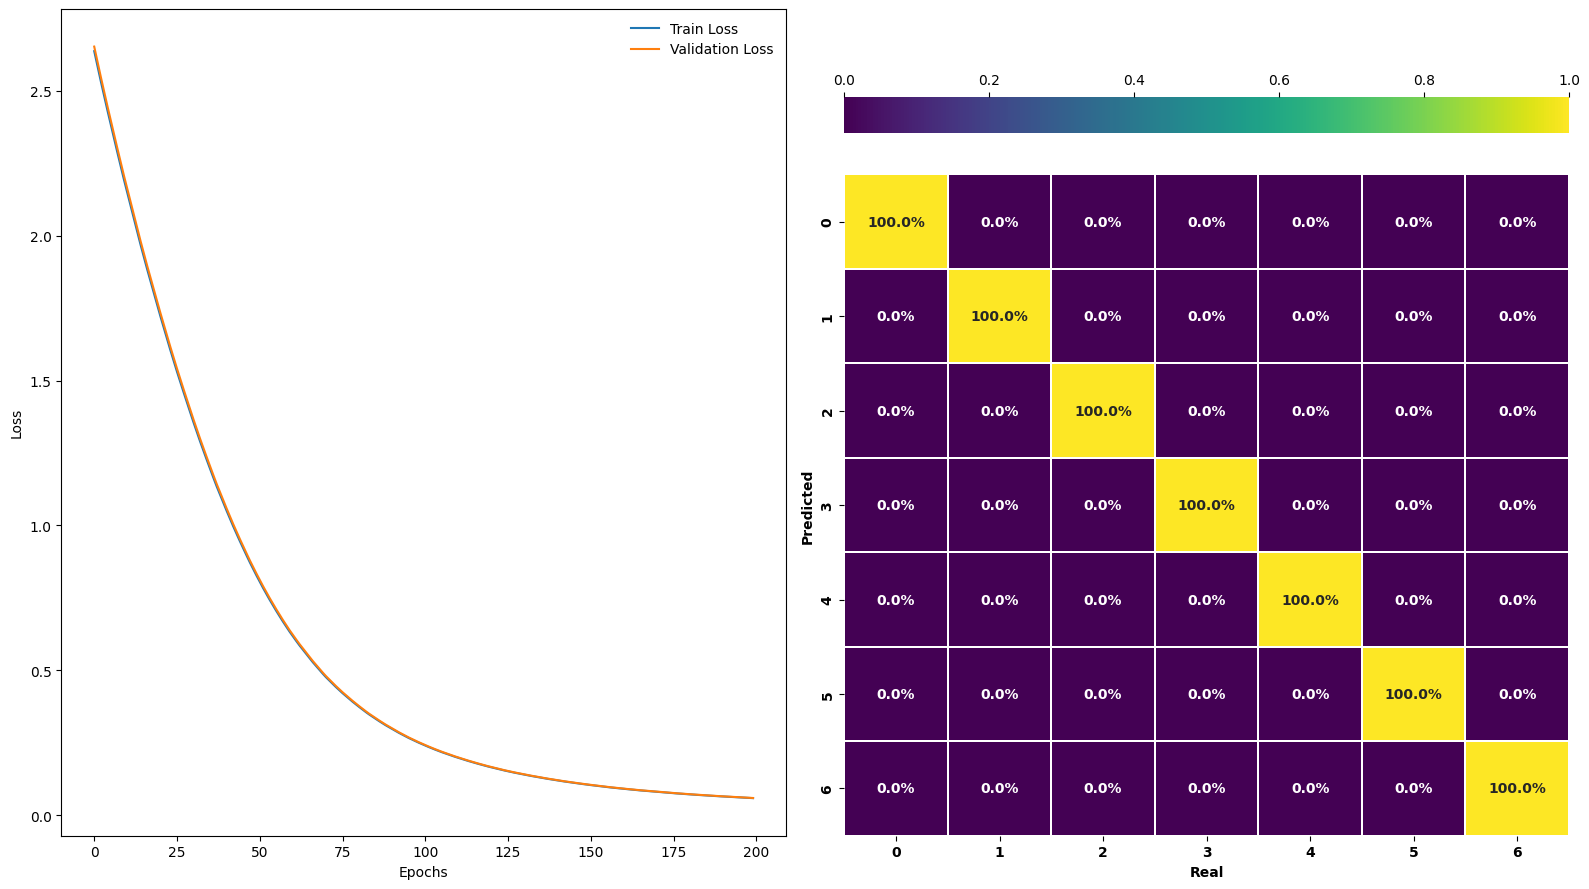

In [135]:
w,b = classifier_NN(X_train,y_train,X_val,y_val)

In [136]:
def NN_predictions(var, tar, weights, bias):
    test_softmax_probs = np.exp(var@weights+bias)/np.sum(np.exp(var@weights+bias), axis=1, keepdims=True)
    test_loss = np.mean(-np.log(test_softmax_probs[range(len(var)), tar]))
    test_pred = np.argmax(test_softmax_probs, axis=1)
    
    plt.figure(figsize=(9,8))
    ax = sns.heatmap(data=confusion_matrix(tar,test_pred,normalize="true"),cmap="viridis",fmt=".1%",
                     annot=True,annot_kws={"weight":"bold"},cbar_kws={"location":"top"},linecolor="w",linewidth=0.1)
    ax.set_ylabel("Predicted",weight="bold")
    ax.set_xlabel("Real",weight="bold")
    ax.set_xticklabels(list(np.arange(len(np.unique(y)))),weight="bold")
    ax.set_yticklabels(list(np.arange(len(np.unique(y)))),weight="bold")
    ax.set_title("Loss: {:.4f}".format(test_loss),fontsize=10,weight="bold")
    
    plt.tight_layout();

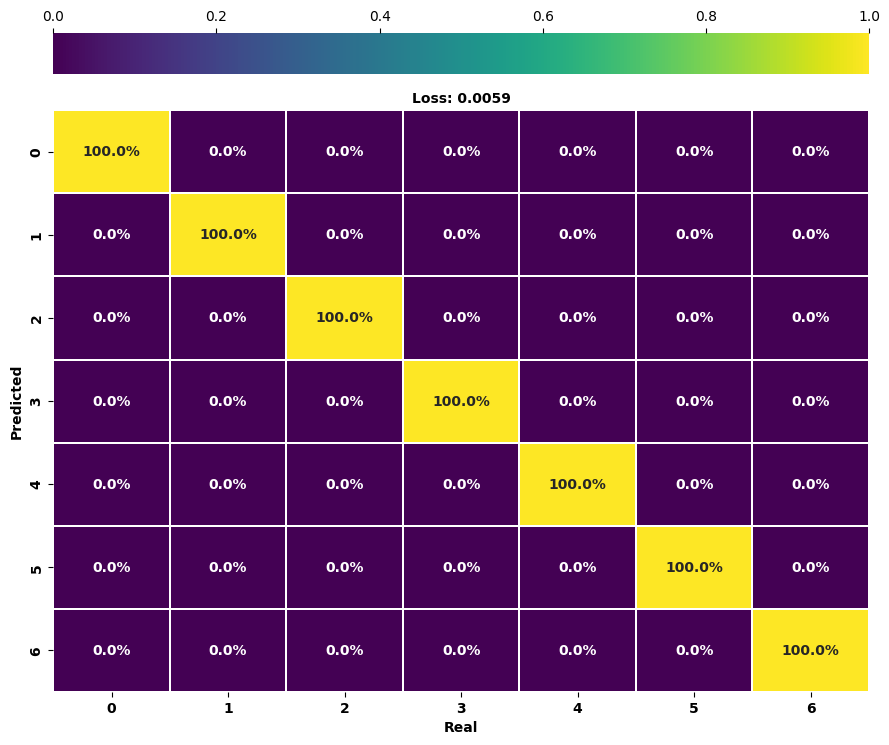

In [134]:
NN_predictions(X_test, y_test, w, b)